In [67]:
import os
import sys
import pandas as pd
import copy
import glob
import pickle
import itertools

from collections import defaultdict

import matplotlib.pyplot as plt

import random 
random.seed(10)



sys.path.append('../src/utilities/')
from ML_benchmark_datasets import return_STRINGFulllPhyBalancePhylaPPI_benchmark_PPs
from STRING_benchmark import  get_STRING1105_physical_interact
from PPI_benchmark_filter import get_PPIwithLimitedProFreByOr

In [33]:
notebookData_folder="/mnt/mnemo6/tao/notebook_data/"  #"/mnt/mnemo6/tao/" /mnt/mnemo6/tao/notebook_data/

In [42]:
Query_tuple=('1224', '511145')

In [35]:
CoEvo_data_folder=notebookData_folder+"PPI_Coevolution/CoEvo_data_STRING11.5/" #"/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/",/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/
Query_input_root_folder=CoEvo_data_folder+"allPPI_"+Query_tuple[1]+"_EggNOGmaxLevel"+Query_tuple[0]+"_eggNOGfilteredData/"
Query_Benchmark_folder=Query_input_root_folder+"AllPPI_Benchmark/"
Query_ML_inputPath=Query_Benchmark_folder+"ML_inputs/"

Query_DCA_coevolutoin_path=Query_input_root_folder+"coevolutoin_result_DCA/"

print(f"Query_Benchmark_folder:{Query_Benchmark_folder}")
print(f"Query_DCA_coevolutoin_path:{Query_DCA_coevolutoin_path}")


Query_Benchmark_folder:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/AllPPI_Benchmark/
Query_DCA_coevolutoin_path:/mnt/mnemo6/tao/notebook_data/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/coevolutoin_result_DCA/


# initial large machine learning benchmark

original code from MNF/notebooks/ScienceCluster_code/STRING_Data_11.5/identifyNovelPPI_phylumeffect_allEcoliPPI_visulization_fullHomologous_oneBestHomologousPP_STRINGFullPhyBalancePhyla.ipynb




In [36]:
# %%time 

#this are collected from all DCA results, skip it if you dont genenerate all DCA results 
if not os.path.exists(Query_Benchmark_folder+"allPPI_allInfo_frame.csv"):
    Query_existed_pydcaFNAPC_files=glob.glob(Query_DCA_coevolutoin_path+"*_pydcaFNAPC_array.npz")
    print(len(Query_existed_pydcaFNAPC_files))
    print(Query_existed_pydcaFNAPC_files[0:3])

    Query_existed_pydcaFNAPC_files=[os.path.basename(f) for f in Query_existed_pydcaFNAPC_files]
    Query_existed_pydcaFNAPC_pps=[f.split("and") for f in Query_existed_pydcaFNAPC_files]
    Query_existed_pydcaFNAPC_pps=[(p1,p2[:-21]) for p1, p2 in Query_existed_pydcaFNAPC_pps]



    newSTRING_rootFolder=f"{notebookData_folder}PPI_Coevolution/STRING_data_11.5/"
    Query_currentSpeMiddleDataPath=newSTRING_rootFolder+Query_tuple[1]+"_EggNOGmaxLevel"+Query_tuple[0]+"_MiddleData/"
    with open(Query_currentSpeMiddleDataPath+'fasta_protein_lens_dict.pickle', 'rb') as handle:
        Query_fasta_protein_lens=pickle.load(handle) 

    Query_existed_pydcaFNAPC_pps_info=[[p1,p2,Query_fasta_protein_lens[p1],Query_fasta_protein_lens[p2]] for p1 , p2 in Query_existed_pydcaFNAPC_pps]
    print("len(Query_existed_pydcaFNAPC_pps_info):",len(Query_existed_pydcaFNAPC_pps_info))

    print("Query_existed_pydcaFNAPC_pps_info[0:3]:",Query_existed_pydcaFNAPC_pps_info[0:3])

    Query_allPPI_allInfo_frame=pd.DataFrame(Query_existed_pydcaFNAPC_pps_info,
                                        columns=["STRING_ID1","STRING_ID2","len1","len2"]
                                            )
    Query_allPPI_allInfo_frame.head(n=3)


    # Query_allPPI_allInfo_frame.to_csv(Query_Benchmark_folder+"allPPI_allInfo_frame.csv",header=True,index=None,sep="\t")

else:
    Query_allPPI_allInfo_frame=pd.read_csv(Query_Benchmark_folder+"allPPI_allInfo_frame.csv",
                                     header=0,index_col=None,sep="\t")
    print(Query_allPPI_allInfo_frame.shape)
    Query_allPPI_allInfo_frame.head(n=3)

(2269192, 4)


In [37]:
%%time
ML_pos_benchmarkFrame_dict=get_STRING1105_physical_interact(data_folder=f"{notebookData_folder}STRING_derived_v11.5/download_files/protein.physical.links.v11.5/",
                                retrieve_spe=511145,
                                combined_score_thres=500,
                                inputFrameIsReversed=True,
                                return_dict=True,)
len(ML_pos_benchmarkFrame_dict)


STRINGcurrentSpePhyPPI_benchmark.shape: (53300, 3)
STRINGcurrentSpePhyPPI_benchmark.shape: (15476, 3)
CPU times: user 28.8 ms, sys: 8.55 ms, total: 37.3 ms
Wall time: 112 ms


15476

In [38]:
%%time 
# this is a reversed file alread :(p1,p2),(p2,p1)
Ecoli_string_score_filename=f"{notebookData_folder}PPI_Coevolution/STRING_data_11.5/"+"511145.protein.links.detailed.v11.5.txt.gz"

Ecoli_string_score=pd.read_csv(Ecoli_string_score_filename,
                               header=0,index_col=None,sep=" ")
Ecoli_string_score_list=Ecoli_string_score.loc[:,["protein1","protein2","combined_score"]].values.tolist()
Ecoli_string_score_dict=dict([((p1,p2),s)for p1, p2, s in Ecoli_string_score_list])

print(Ecoli_string_score.shape)

(1083186, 10)
CPU times: user 2.07 s, sys: 1.87 s, total: 3.95 s
Wall time: 4.04 s


In [39]:
input_allPPs_list=Query_allPPI_allInfo_frame.values.tolist()
input_allPPs_list=[(p1,p2) for p1,p2,_,_ in input_allPPs_list]

len(currentSpe_STRINGFulllPhyBalancePhylaPPI_posPPI): 5532
1057
len(currentSpe_STRINGFulllPhyBalancePhylaPPI_negPPI): 2263660
len(currentSpe_STRINGFulllPhyBalancePhylaPPI_negPPI): 482366
string filtering,len(currentSpe_STRINGFulllPhyBalancePhylaPPI_negPPI) 414880
frequency filtering ,len(currentSpe_STRINGFulllPhyBalancePhylaPPI_negPPI): 414880
len(currentSpe_STRINGPhyBalancePhylaPPI_negPPI_ProFreDict): 1057


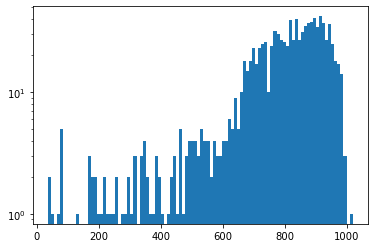

In [40]:


currentSpe_STRINGFulllPhyBalancePhylaPPI_posPPI,currentSpe_STRINGFulllPhyBalancePhylaPPI_negPPI=return_STRINGFulllPhyBalancePhylaPPI_benchmark_PPs(ML_pos_benchmarkFrame_dict,
                                                       input_allPPs_list
                                                                                                                                                   ,
                                                       Ecoli_string_score_dict,
                                                       limitedProFre=100000,
                                                      )

currentSpe_STRINGFulllPhyBalancePhylaPPI_frame_list=list()
for p1,p2 in currentSpe_STRINGFulllPhyBalancePhylaPPI_posPPI:
    currentSpe_STRINGFulllPhyBalancePhylaPPI_frame_list.append([p1,p2,"P",])

for p1,p2 in currentSpe_STRINGFulllPhyBalancePhylaPPI_negPPI:
    currentSpe_STRINGFulllPhyBalancePhylaPPI_frame_list.append([p1,p2,"N",])
currentSpe_STRINGFulllPhyBalancePhylaPPI_frame=pd.DataFrame(currentSpe_STRINGFulllPhyBalancePhylaPPI_frame_list,
                                                            columns=["STRING_ID1","STRING_ID2","benchmark_status"])

# currentSpe_STRINGFulllPhyBalancePhylaPPI_frame.to_csv("/net/cephfs/shares/von-mering.imls.uzh/tao/PPI_Coevolution/CoEvo_data_STRING11.5/allPPI_511145_EggNOGmaxLevel1224_eggNOGfilteredData/STRINGFullPhyBalancePhyla_Benchmark/allPPI_allInfo_frame.csv",
#                                                       sep="\t",header=True,index=None)






In [41]:
currentSpe_STRINGFulllPhyBalancePhylaPPI_frame.shape

(420412, 3)

# smaller benchmark dataset at  taxononical levels to test effect of different alignment strategies


original code from code/MNF/notebooks/STRING_Data_11.5/script_CoEvo_EggNOG_preprocessing_STRING1105_varyEggNOGMaxLevels_prepareSTRINPhyPPIBenchmark.py


It generated similar as above but we just dont limit the frequency of each protein of negative PPI to limit the dataset for the sake of computational time.


In [53]:

newSTRING_rootFolder=f"{notebookData_folder}PPI_Coevolution/STRING_data_11.5/"
Query_currentSpeMiddleDataPath=newSTRING_rootFolder+Query_tuple[1]+"_EggNOGmaxLevel"+Query_tuple[0]+"_MiddleData/"

with open(Query_currentSpeMiddleDataPath+'fasta_protein_lens_dict.pickle', 'rb') as handle:
    fasta_protein_lens=pickle.load(handle) 

In [51]:
        STRINGcurrentSpePhyPPI_benchmark_file="/mnt/mnemo6/damian/STRING_derived_v11.5/download_files/protein.physical.links.v11.5/511145.protein.physical.links.v11.5.txt.gz"
        STRINGcurrentSpePhyPPI_benchmark=pd.read_csv(STRINGcurrentSpePhyPPI_benchmark_file,sep=" ",
                                       header=0,index_col=None)

        print("STRINGcurrentSpePhyPPI_benchmark.shape:",STRINGcurrentSpePhyPPI_benchmark.shape)

        STRINGcurrentSpePhyPPI_benchmark=STRINGcurrentSpePhyPPI_benchmark.loc[STRINGcurrentSpePhyPPI_benchmark['combined_score']>500,:]
        print("STRINGcurrentSpePhyPPI_benchmark.shape:",STRINGcurrentSpePhyPPI_benchmark.shape)

        STRINGcurrentSpePhyPPI_benchmark=STRINGcurrentSpePhyPPI_benchmark.sort_values(by="combined_score",ascending=False)

        STRINGcurrentSpePhyPPI_benchmark.head(n=3)



        currentSpe_STRINGcurrentSpePhyPPI_posPPI=STRINGcurrentSpePhyPPI_benchmark.loc[:,["protein1","protein2"]].values.tolist()



        # here rememver one thing different 
        # if we start to calculate dca score only for ppi in benchmark dataset, we shouldnt use use reversed version of pp
        # its a litter different as we do in Ecoli_KEGG , where we first calcuate dca for all protein pari in this species 
        currentSpe_STRINGcurrentSpePhyPPI_posPPI=[tuple(sorted(pp)) for pp in currentSpe_STRINGcurrentSpePhyPPI_posPPI]
        currentSpe_STRINGcurrentSpePhyPPI_posPPI=list(set(currentSpe_STRINGcurrentSpePhyPPI_posPPI))


        currentSpe_STRINGcurrentSpePhyPPI_posPPI=[tuple(ppi) for ppi in currentSpe_STRINGcurrentSpePhyPPI_posPPI]
        # here need to make sure both protein have alignment data 
        currentSpe_STRINGcurrentSpePhyPPI_posPPI=[(p1,p2)for p1, p2 in currentSpe_STRINGcurrentSpePhyPPI_posPPI if (p1 in Query_fasta_protein_lens) and (p2 in Query_fasta_protein_lens)]

        print("len(currentSpe_STRINGcurrentSpePhyPPI_posPPI):",len(currentSpe_STRINGcurrentSpePhyPPI_posPPI))
        print(currentSpe_STRINGcurrentSpePhyPPI_posPPI[0:3])


        currentSpe_STRINGcurrentSpePhyPPI_posPPI=sorted(list(set(currentSpe_STRINGcurrentSpePhyPPI_posPPI)))
        print("len(currentSpe_STRINGcurrentSpePhyPPI_posPPI)",len(currentSpe_STRINGcurrentSpePhyPPI_posPPI))


        currentSpe_STRINGcurrentSpePhyPPI_posPPI_dict=dict([(pp,1) for pp in currentSpe_STRINGcurrentSpePhyPPI_posPPI])
        print("len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_dict)",len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_dict))
        print(list(currentSpe_STRINGcurrentSpePhyPPI_posPPI_dict.items())[0:3])




        currentSpe_STRINGcurrentSpePhyPPI_allProteins=[p for key in currentSpe_STRINGcurrentSpePhyPPI_posPPI_dict.keys() for p in key ]

        currentSpe_STRINGcurrentSpePhyPPI_allProteins=list(set(currentSpe_STRINGcurrentSpePhyPPI_allProteins))

        # here is import to make sure  every run of this pipeline producing same benchmark 
        currentSpe_STRINGcurrentSpePhyPPI_allProteins= sorted(set(currentSpe_STRINGcurrentSpePhyPPI_allProteins))

        print(currentSpe_STRINGcurrentSpePhyPPI_allProteins[0:3])

        print("len(currentSpe_STRINGcurrentSpePhyPPI_allProteins):",len(currentSpe_STRINGcurrentSpePhyPPI_allProteins))
        currentSpe_STRINGcurrentSpePhyPPI_allProteins_dict=dict([(p,1) for p in currentSpe_STRINGcurrentSpePhyPPI_allProteins])

STRINGcurrentSpePhyPPI_benchmark.shape: (53300, 3)
STRINGcurrentSpePhyPPI_benchmark.shape: (15476, 3)
len(currentSpe_STRINGcurrentSpePhyPPI_posPPI): 6952
[('511145.b0098', '511145.b3315'), ('511145.b1094', '511145.b2563'), ('511145.b0083', '511145.b2748')]
len(currentSpe_STRINGcurrentSpePhyPPI_posPPI) 6952
len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_dict) 6952
[(('511145.b0008', '511145.b4034'), 1), (('511145.b0009', '511145.b1727'), 1), (('511145.b0014', '511145.b0015'), 1)]
['511145.b0008', '511145.b0009', '511145.b0014']
len(currentSpe_STRINGcurrentSpePhyPPI_allProteins): 1410


In [56]:
        # constructure final positive  PPI 
        currentSpe_STRINGcurrentSpePhyPPI_posPPI_info=[[p1,p2,fasta_protein_lens[p1],fasta_protein_lens[p2]] for p1,p2 in currentSpe_STRINGcurrentSpePhyPPI_posPPI_dict.keys()]
        print("len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_info)",len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_info))


        # constracut negaive PPI using proteins in positive PPI
        currentSpe_STRINGcurrentSpePhyPPI_negPPI=list(itertools.combinations(currentSpe_STRINGcurrentSpePhyPPI_allProteins, 2))
        print("len(currentSpe_STRINGcurrentSpePhyPPI_negPPI)",len(currentSpe_STRINGcurrentSpePhyPPI_negPPI))
        currentSpe_STRINGcurrentSpePhyPPI_negPPI=[(p1,p2) for p1,p2 in currentSpe_STRINGcurrentSpePhyPPI_negPPI if (((p1,p2) not in currentSpe_STRINGcurrentSpePhyPPI_posPPI_dict) and ((p2,p1) not in currentSpe_STRINGcurrentSpePhyPPI_posPPI_dict)) ]
        print("len(currentSpe_STRINGcurrentSpePhyPPI_negPPI):",len(currentSpe_STRINGcurrentSpePhyPPI_negPPI))

len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_info) 6952
len(currentSpe_STRINGcurrentSpePhyPPI_negPPI) 993345
len(currentSpe_STRINGcurrentSpePhyPPI_negPPI): 986393


In [60]:
        # here shuffle negative ppi randomly 
        random.Random(10).shuffle(currentSpe_STRINGcurrentSpePhyPPI_negPPI)
        print(currentSpe_STRINGcurrentSpePhyPPI_negPPI[0:3])



        currentSpe_STRINGcurrentSpePhyPPI_negPPI_info=[[p1,p2,fasta_protein_lens[p1],fasta_protein_lens[p2]] for p1,p2 in currentSpe_STRINGcurrentSpePhyPPI_negPPI]
        print("len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_info):",len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_info))


        #%%time
        # constructure final positive and negigeve PPI using string score 

        #currentSpe_STRINGcurrentSpePhyPPI_negPPI_info=[l for l in currentSpe_STRINGcurrentSpePhyPPI_negPPI_info if  ((l[0],l[1]) not in Ecoli_string_score_dict) or (Ecoli_string_score_dict[(l[0],l[1])]==0)]
        currentSpe_STRINGcurrentSpePhyPPI_negPPI_info=[l for l in currentSpe_STRINGcurrentSpePhyPPI_negPPI_info if  ((l[0],l[1]) not in Ecoli_string_score_dict) ]

        print("len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_info)",len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_info))



[('511145.b0470', '511145.b2609'), ('511145.b0722', '511145.b1917'), ('511145.b0545', '511145.b3270')]
len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_info): 986393
len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_info) 883101


In [63]:
        ## here we  limited frquence of protein in postive and negative dataset. 
        ## acturally only for negative now 
        ## futer post-filter step can be applied later , for example by Remove Ribosome protein or not 
        currentSpe_STRINGcurrentSpePhyPPI_negPPI_info=get_PPIwithLimitedProFreByOr(currentSpe_STRINGcurrentSpePhyPPI_negPPI_info)
        print("len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_info):",len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_info))

len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_info): 23478


len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_ProFreDict): 1410


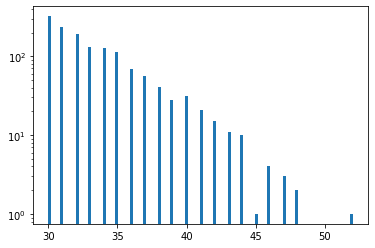

In [68]:
        currentSpe_STRINGcurrentSpePhyPPI_negPPI_ProFreDict=defaultdict(int)
        for p1,p2, _,_ in currentSpe_STRINGcurrentSpePhyPPI_negPPI_info:
            currentSpe_STRINGcurrentSpePhyPPI_negPPI_ProFreDict[p1] +=1
            currentSpe_STRINGcurrentSpePhyPPI_negPPI_ProFreDict[p2] +=1


        print("len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_ProFreDict):",len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_ProFreDict))
        len([v for v in currentSpe_STRINGcurrentSpePhyPPI_negPPI_ProFreDict.values() if v >50])

        plt.hist(currentSpe_STRINGcurrentSpePhyPPI_negPPI_ProFreDict.values(),bins=100)
        #plt.xscale('log')
        plt.yscale('log')
        plt.show()


In [70]:
        currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps=[(l[0],l[1]) for l in currentSpe_STRINGcurrentSpePhyPPI_posPPI_info]
        currentSpe_STRINGcurrentSpePhyPPI_negPPI_pps=[(l[0],l[1]) for l in currentSpe_STRINGcurrentSpePhyPPI_negPPI_info]
        print("len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps):",len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps),len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_pps),len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps)+len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_pps))


len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps): 6952 23478 30430


In [72]:
        currentSpe_TaxID="5111145"
        EggNOG_maxLevel="1224"
        CoEvo_data_folder="/mnt/mnemo6/tao/PPI_Coevolution/CoEvo_data_STRING11.5/"


        input_root_folder=CoEvo_data_folder+currentSpe_TaxID+"_EggNOGmaxLevel"+EggNOG_maxLevel+"_eggNOGfilteredData/"

        Benchmark_folder=input_root_folder+"STRINPhyPPI_Benchmark/"


        pairedMSA_unfiltered_folder=input_root_folder+"pair_MSA_unfiltered_PasteAlign/"

In [ ]:




        # ## get postivte and negative ppi  second setp (after get all needed final paired MSA)
        # by  same protein ratio on two side of MSA 
        # first need to update postive and negative ppi to only use pp that have large Nf90 value 
        pairedMSA_Nf90_frame = pd.read_csv(pairedMSA_Nf90_csv,header=None,index_col=None,sep="\t")
        print("pairedMSA_Nf90_frame.shape:",pairedMSA_Nf90_frame.shape)

        pairedMSA_Nf90_list=pairedMSA_Nf90_frame.iloc[:,[0,1]].values.tolist()
        pairedMSA_Nf90_dict=dict([((p1,p2),1) for p1, p2 in pairedMSA_Nf90_list])

        currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps=[pp for pp in currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps if pp in pairedMSA_Nf90_dict]
        currentSpe_STRINGcurrentSpePhyPPI_negPPI_pps=[pp for pp in currentSpe_STRINGcurrentSpePhyPPI_negPPI_pps if pp in pairedMSA_Nf90_dict]
        print("len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps):",len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps))
        print("len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_pps):",len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_pps))


        # In[ ]:


        #%%time 

        #heck paired MSA of homologus , if same proteins  from same species in both side

        if os.path.getsize(pairedMSA_sameProteinRatio_csv) == 0:
            pairedMSA_sameProteinRatio_dict=dict()
        else:
            pairedMSA_sameProteinRatio_frame = pd.read_csv(pairedMSA_sameProteinRatio_csv,header=None,index_col=None,sep="\t")
            pairedMSA_sameProteinRatio_list=pairedMSA_sameProteinRatio_frame.values.tolist()
            pairedMSA_sameProteinRatio_dict=dict([((p1,p2),r) for p1 , p2 , r in pairedMSA_sameProteinRatio_list])
            #print(pairedMSA_sameProteinRatio_frame.shape)

        currentSpe_STRINGcurrentSpePhyPPI_allPPI_pps=currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps+currentSpe_STRINGcurrentSpePhyPPI_negPPI_pps
        currentSpe_STRINGcurrentSpePhyPPI_allPPI_ArgForSamePro=[(p1,p2,pairedMSA_Nf90_folder) for p1, p2, in currentSpe_STRINGcurrentSpePhyPPI_allPPI_pps if (p1, p2) not in pairedMSA_sameProteinRatio_dict]
        print("len(currentSpe_STRINGcurrentSpePhyPPI_allPPI_ArgForSamePro):",len(currentSpe_STRINGcurrentSpePhyPPI_allPPI_ArgForSamePro))

        if len(currentSpe_STRINGcurrentSpePhyPPI_allPPI_ArgForSamePro)>0:
            pool=mp.Pool(50)
            sameProtein_ratio_results=pool.map(getSameProteinRatio,currentSpe_STRINGcurrentSpePhyPPI_allPPI_ArgForSamePro)
            pool.close() 


            sameProtein_ratio_frame=pd.DataFrame(sameProtein_ratio_results,columns=["protein1","protein2","saemProtein_ratio"])
            sameProtein_ratio_frame.to_csv(pairedMSA_sameProteinRatio_csv,mode="a",
                                header=None,index=None,sep="\t")
            print(sameProtein_ratio_frame.shape)

        # CPU times: user 144 ms, sys: 639 ms, total: 783 ms
        # Wall time: 53.2 s


        # In[ ]:


        # remove protein pair with same prortein on two side of MSA 

        sameProtein_ratio_frame=pd.read_csv(pairedMSA_sameProteinRatio_csv,
                                header=None,index_col=None,sep="\t")
        print(sameProtein_ratio_frame.shape)
        large_sameProtein_ratio_frame=sameProtein_ratio_frame.loc[sameProtein_ratio_frame.iloc[:,2]>0,:]
        print(large_sameProtein_ratio_frame.shape)

        large_sameProtein_ratio_dict=dict([((p1,p2),r) for p1,p2,r in large_sameProtein_ratio_frame.values.tolist()])




        currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps=[pp for pp in currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps if pp not in large_sameProtein_ratio_dict]
        print("len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps):",len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps))


        currentSpe_STRINGcurrentSpePhyPPI_negPPI_pps=[pp for pp in currentSpe_STRINGcurrentSpePhyPPI_negPPI_pps if pp not in large_sameProtein_ratio_dict]
        print("len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_pps):",len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_pps))


        # In[ ]:




        currentSpe_STRINGcurrentSpePhyPPI_posPPI_beforeCoEvoComp_info=[(p1,p2, "P") for p1, p2 in currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps]
        currentSpe_STRINGcurrentSpePhyPPI_negPPI_beforeCoEvoComp_info=[(p1,p2, "N") for p1, p2 in currentSpe_STRINGcurrentSpePhyPPI_negPPI_pps]

        currentSpe_STRINGcurrentSpePhyPPI_allPPI_beforeCoEvoComp_frame=pd.DataFrame(currentSpe_STRINGcurrentSpePhyPPI_posPPI_beforeCoEvoComp_info+currentSpe_STRINGcurrentSpePhyPPI_negPPI_beforeCoEvoComp_info,
                                                                                   columns=["STRING_ID1","STRING_ID2","benchmark_status"])
        currentSpe_STRINGcurrentSpePhyPPI_allPPI_beforeCoEvoComp_frame.to_csv(Benchmark_folder+"PPIInfoBeforeCoEvoComp.csv",
                                                                             header=True, index=False,sep="\t")

In [ ]:















        
        # ## get paired MSA if pass certain creteria 



        pairedMSA_unfiltered_folder


        # In[ ]:


        #%%time 

        pairedMSA_unfiltered_files =os.listdir(pairedMSA_unfiltered_folder) # here to check if paired MSA already been processed before 
        print("len(pairedMSA_unfiltered_files):",len(pairedMSA_unfiltered_files))
        print(pairedMSA_unfiltered_files[0:3])

        pairedMSA_unfiltered_pps=[f.split("and") for f in pairedMSA_unfiltered_files]
        pairedMSA_unfiltered_pps=[(p1,p2[0:-6]) for p1,p2 in pairedMSA_unfiltered_pps]

        pairedMSA_unfiltered_dict=dict([(f,1) for f in pairedMSA_unfiltered_pps])


        currentSpe_STRINGcurrentSpePhyPPI_posPPI_forPairMSA=[pp for pp in currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps if pp not in pairedMSA_unfiltered_dict]
        currentSpe_STRINGcurrentSpePhyPPI_posPPI_ArgForPairMSA=[(currentSpe_TaxID,currentSpe_hmmalign_path,p1,p2,Nf90_thres,pairedMSA_unfiltered_folder,pairedMSA_hhfilter_folder,pairedMSA_Nf90_folder) for p1,p2 in currentSpe_STRINGcurrentSpePhyPPI_posPPI_forPairMSA]

        currentSpe_STRINGcurrentSpePhyPPI_negPPI_forPairMSA=[pp for pp in currentSpe_STRINGcurrentSpePhyPPI_negPPI_pps if pp not in pairedMSA_unfiltered_dict]
        currentSpe_STRINGcurrentSpePhyPPI_negPPI_ArgForPairMSA=[(currentSpe_TaxID,currentSpe_hmmalign_path,p1,p2,Nf90_thres,pairedMSA_unfiltered_folder,pairedMSA_hhfilter_folder,pairedMSA_Nf90_folder) for p1,p2 in currentSpe_STRINGcurrentSpePhyPPI_negPPI_forPairMSA]

        print("len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps),len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_pps)")
        print(len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_pps),len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_pps))
        print(len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_ArgForPairMSA),len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_ArgForPairMSA))

        # #run once #actually this is not necesseary  as function will check  if files is still existed 


        if len(currentSpe_STRINGcurrentSpePhyPPI_posPPI_ArgForPairMSA)>0:
            #pool=mp.Pool(50)   #mp.Pool(160) 
            pool=get_context("spawn").Pool(50)
            get_pairedMSA_inOneRun_result=pool.map(get_pairedMSA_inOneRun,currentSpe_STRINGcurrentSpePhyPPI_posPPI_ArgForPairMSA)
            pool.close() 


            get_pairedMSA_inOneRun_result=[s for s in get_pairedMSA_inOneRun_result if s is not None]
            get_pairedMSA_inOneRun_result_frame=pd.DataFrame(get_pairedMSA_inOneRun_result,columns=["protein1","protein2","L1","L2","Nf90"])
            get_pairedMSA_inOneRun_result_frame.to_csv(pairedMSA_Nf90_csv,mode="a",
                                header=None,index=None,sep="\t")
            print(get_pairedMSA_inOneRun_result_frame.shape)



        if len(currentSpe_STRINGcurrentSpePhyPPI_negPPI_ArgForPairMSA)>0:

            #pool=mp.Pool(50)   #mp.Pool(160) 
            pool=get_context("spawn").Pool(50)
            get_pairedMSA_inOneRun_result=pool.map(get_pairedMSA_inOneRun,currentSpe_STRINGcurrentSpePhyPPI_negPPI_ArgForPairMSA)
            pool.close() 


            get_pairedMSA_inOneRun_result=[s for s in get_pairedMSA_inOneRun_result if s is not None]
            get_pairedMSA_inOneRun_result_frame=pd.DataFrame(get_pairedMSA_inOneRun_result,columns=["protein1","protein2","L1","L2","Nf90"])
            get_pairedMSA_inOneRun_result_frame.to_csv(pairedMSA_Nf90_csv,mode="a",
                                header=None,index=None,sep="\t")
            print(get_pairedMSA_inOneRun_result_frame.shape)


        # CPU times: user 1.01 s, sys: 1.55 s, total: 2.56 s
        # Wall time: 5min 34s


        # In[ ]:


        #??? why so few ???


        # In[ ]:





        # In[ ]:





        # In[ ]:





        # In[ ]:





        # In[ ]:


